# COLLECT CANCER DATA FROM UK BIOBANK


### CONSIDERING BOTH ICD10 AND ICD9

### 1. Upload cancer datafields per patient 
### 2. Create general variables
### 3. Create variable difference ages
### 4. Hematological cancer
### 5. Calculate time in date
### 6. Create variable hematopoietic cancer from 1st cancer (post age)
### 7. Labeling and classifying hematological cancer
### 8. Save output

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

## 1. Upload cancer datafields per patient 

In [4]:
### OPEN CANCER DATA generated following the steps from the README.md
### Data-fields are indicated in the paper

# Read data
filename = "/workspace/datasets/ukbiobank_ch/ukb_data_670124/clinical_data_ukb670124/cancer_data_670124.txt"
lines = ''.join([line for line in open(filename, 'rt')])

# Transform to df
cancer_ukb200k = pd.read_csv(StringIO(lines), sep= '\t')
len(cancer_ukb200k)

/tmp/jobs/jramis/9874679/ipykernel_53556/176269524.py:8: DtypeWarning: Columns (56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221) have mixed types. Specify dtype option on import or set low_memory=False.
  cancer_df = pd.read_csv(StringIO(lines), sep= '\t')


502394

In [15]:
# All datafield codes

colnoms = []
for x in cancer_ukb200k.columns.tolist():
    colnoms.append(x.split('-')[0])
set(colnoms)

{'21003',
 '21022',
 '22009',
 '31',
 '40005',
 '40006',
 '40008',
 '40009',
 '40011',
 '40012',
 '40013',
 '40019',
 '40021',
 '53',
 'eid'}

'eid', case_id\
'40005', date of cancer\
'40006', Type of cancer: ICD10\
'40008', Age at cancer diagnosis\
'40009', Reported occurrences of cancer\
'40013', Type of cancer: ICD9\
'53', Date of attending assessment centre\
'21003', Age when attended assessment centre\
'21022', Age at recruitment\
'22009', Genetic principal components\
'31', Sex\
'40011', Histology of cancer tumour\
'40012', Behaviour of cancer tumour\
'40019', Cancer record format\
'40021', Cancer record origin\

In [16]:
# Function to obtain the index from columns

def columna(data, name):
    a = []
    for n, x in enumerate(data.columns.tolist()):
        if str(x).startswith(str(name)):
            a.append([n , x])
    return(a)

In [17]:
columna(cancer_ukb200k, '40005')

[[51, '40005-0.0'],
 [52, '40005-1.0'],
 [53, '40005-2.0'],
 [54, '40005-3.0'],
 [55, '40005-4.0'],
 [56, '40005-5.0'],
 [57, '40005-6.0'],
 [58, '40005-7.0'],
 [59, '40005-8.0'],
 [60, '40005-9.0'],
 [61, '40005-10.0'],
 [62, '40005-11.0'],
 [63, '40005-12.0'],
 [64, '40005-13.0'],
 [65, '40005-14.0'],
 [66, '40005-15.0'],
 [67, '40005-16.0'],
 [68, '40005-17.0'],
 [69, '40005-18.0'],
 [70, '40005-19.0'],
 [71, '40005-20.0'],
 [72, '40005-21.0']]

In [18]:
#calculate max date of cancer event

dates = cancer_ukb200k.iloc[:,51:73]
maxdates = []
for x in dates:
    maxdates.append(pd.to_datetime(cancer_ukb200k[x], format='%Y-%m-%d').max())
maxdate = max(maxdates)
maxdate

Timestamp('2021-06-25 00:00:00')

In [ ]:
## 2. Start generating matrix

In [24]:
### Select only relevant data

# 40005 [51:73]  Date of first cancer
# 40006 [73:95]  Cancer - ICD10
# 40008 [95:117]  Age of first cancer
# 40013 [162:177]  Cancer - ICD9
# 40009 [117]  Cancer ocurrences


# Select data fields 40005, 40006, 40008, 40013 and 40009
cancer_ukb200k = pd.concat([cancer_ukb200k[cancer_ukb200k.columns[0]],
                                cancer_ukb200k[cancer_ukb200k.columns[2]],
                                cancer_ukb200k[cancer_ukb200k.columns[51:73]],
                                cancer_ukb200k[cancer_ukb200k.columns[73:95]],
                                cancer_ukb200k[cancer_ukb200k.columns[95:117]],
                                cancer_ukb200k[cancer_ukb200k.columns[162:177]],
                                cancer_ukb200k[cancer_ukb200k.columns[117]]], axis=1)

## 2. Create general variables

In [33]:
### Patients with cancer
#cancer defined as having date of cancer, it should be 40009 (ocurrences)
ukb200K_age_cancer['cancer'] = ukb200K_age_cancer['40009-0.0'].apply(lambda x: 0 if pd.isna(x) else 1)
ukb200K_age_cancer['cancer'].value_counts()

0    383413
1    118978
Name: cancer, dtype: int64

In [34]:
### Patients with 2+ cancers
# Considering field '40009-0.0': Summary number of reports

ukb200K_age_cancer['cancer2+'] = ukb200K_age_cancer['40009-0.0'].apply(lambda x: 1 if x>1 else 0)
ukb200K_age_cancer['cancer2+'].value_counts()

0    470965
1     31426
Name: cancer2+, dtype: int64

In [35]:
# Check

print(sum(ukb200K_age_cancer['40009-0.0'].value_counts().to_list()[1:]))

ukb200K_age_cancer[ukb200K_age_cancer['cancer2+']==1]['40009-0.0'].value_counts()

31426


2.0     23913
3.0      5616
4.0      1402
5.0       337
6.0       103
7.0        33
8.0        13
9.0         3
12.0        2
13.0        1
18.0        1
22.0        1
10.0        1
Name: 40009-0.0, dtype: int64

## 3. Create variable difference ages

In [57]:
columna(ukb200K_age_cancer, 40008)

[[49, '40008-0.0'],
 [50, '40008-1.0'],
 [51, '40008-2.0'],
 [52, '40008-3.0'],
 [53, '40008-4.0'],
 [54, '40008-5.0'],
 [55, '40008-6.0'],
 [56, '40008-7.0'],
 [57, '40008-8.0'],
 [58, '40008-9.0'],
 [59, '40008-10.0'],
 [60, '40008-11.0'],
 [61, '40008-12.0'],
 [62, '40008-13.0'],
 [63, '40008-14.0'],
 [64, '40008-15.0'],
 [65, '40008-16.0'],
 [66, '40008-17.0'],
 [67, '40008-18.0'],
 [68, '40008-19.0'],
 [69, '40008-20.0'],
 [70, '40008-21.0']]

In [35]:
### Age first cancer
def age_first_cancer(patient):
    # Patients with 1 cancer
    if (patient['cancer'] == 1):
        # check 40008
        ages = patient[49:71]
        return min(ages)
            
ukb200K_age_cancer['age_1cancer'] = ukb200K_age_cancer.apply(lambda x: age_first_cancer(x), axis=1)

In [36]:
### First cancer previous than blood sample (CH)

ukb200K_age_cancer['cancer1_pre'] = ukb200K_age_cancer['years_tocancer1'].apply(lambda x: 1 if x < -1 else 0)

In [37]:
### Type first cancer (ICD10) 40006
def type_first_cancer(patient):
    # Patients with only 1 cancer diagnosis
    if (patient['cancer'] == 1):
            ages = list(patient[49:71])
            i_minage = ages.index(min(ages))
            return patient[27 + i_minage]
            
ukb200K_age_cancer['type_1cancer'] = ukb200K_age_cancer.apply(lambda x: type_first_cancer(x), axis=1)

## 4. Hematological cancer
not necessarily the first, with the extended definition and icd10+icd9)

In [75]:
### Deffinition of hemato cancer icd10 AND icd9

hemcancer_icd10 = ('C81','C82','C83','C84','C85','C86','C88','C90','C91','C92','C93','C94','C95','C96',
                   'D45','D46','D47')

hemcancer_icd9 = ('200', '201','202','203','204','205','206','207','208','2387')

hemcancer_icd10icd9 = ('C81','C82','C83','C84','C85','C86','C88','C90','C91','C92','C93','C94','C95','C96',
                       'D45','D46','D47',
                      '200', '201','202','203','204','205','206','207','208','2387')

In [82]:
columna(ukb200K_age_cancer, 40006)

[[27, '40006-0.0'],
 [28, '40006-1.0'],
 [29, '40006-2.0'],
 [30, '40006-3.0'],
 [31, '40006-4.0'],
 [32, '40006-5.0'],
 [33, '40006-6.0'],
 [34, '40006-7.0'],
 [35, '40006-8.0'],
 [36, '40006-9.0'],
 [37, '40006-10.0'],
 [38, '40006-11.0'],
 [39, '40006-12.0'],
 [40, '40006-13.0'],
 [41, '40006-14.0'],
 [42, '40006-15.0'],
 [43, '40006-16.0'],
 [44, '40006-17.0'],
 [45, '40006-18.0'],
 [46, '40006-19.0'],
 [47, '40006-20.0'],
 [48, '40006-21.0']]

In [38]:
def hemato_cancer(patient):
    if (patient['cancer'] == 1):
        cancer_types_icd10 = patient[27:49]
        hemo_cancers_icd10 = [i for i in cancer_types_icd10 if str(i).startswith(hemcancer_icd10)]
        cancer_types_icd9 = patient[71:86]
        hemo_cancers_icd9 = [i for i in cancer_types_icd9 if str(i).startswith(hemcancer_icd9)]
        if hemo_cancers_icd10 or hemo_cancers_icd9:
            return 1
        else:
            return 0
    else:
        return 0

ukb200K_age_cancer['hemato_cancer'] = ukb200K_age_cancer.apply(lambda x: hemato_cancer(x), axis=1)

In [84]:
columna(ukb200K_age_cancer, 40006)

[[27, '40006-0.0'],
 [28, '40006-1.0'],
 [29, '40006-2.0'],
 [30, '40006-3.0'],
 [31, '40006-4.0'],
 [32, '40006-5.0'],
 [33, '40006-6.0'],
 [34, '40006-7.0'],
 [35, '40006-8.0'],
 [36, '40006-9.0'],
 [37, '40006-10.0'],
 [38, '40006-11.0'],
 [39, '40006-12.0'],
 [40, '40006-13.0'],
 [41, '40006-14.0'],
 [42, '40006-15.0'],
 [43, '40006-16.0'],
 [44, '40006-17.0'],
 [45, '40006-18.0'],
 [46, '40006-19.0'],
 [47, '40006-20.0'],
 [48, '40006-21.0']]

In [39]:
### First Hemato Cancer (ICD10)

# Type of the first Hemato Cancer (ICD10)
def hematocancer_icd10_type(patient):
    # Patients with 1 or more hemato cancer and icd10 annotation
    if (patient['hemato_cancer'] == 1) & (patient['eid'] in hematocases_icd10):
#         # Patients with exactly 1 hemato cancer and no more cancers
#         if (patient['cancer2+'] == 0):
#             if pd.notna(patient['40006-0.0']):
#                 return patient['40006-0.0']
#         # Patients with more cancers
#         else:
            cancer_types = patient[27:49]
            hemo_cancers = [i for i in cancer_types if str(i).startswith(hemcancer_icd10)]
            i_hemo_cancers = [i for i,j in enumerate(cancer_types) if str(j).startswith(hemcancer_icd10)]
            # Only 1 hemato cancer (the other cancer(s) are not hemato)
            if len(hemo_cancers) == 1:
                return cancer_types[i_hemo_cancers].array[0]
            # More than 1 heamto cancer
            elif len(hemo_cancers) > 1:
                ages = patient[49:71]
                ages_hemocancers = [ages[index] for index in i_hemo_cancers]
                minage = min(ages_hemocancers)
                i_minage = ages_hemocancers.index(minage)
                return hemo_cancers[i_minage]
            else:
                print("icd9")
    else:
        return np.nan
    
                
ukb200K_age_cancer['hematocancer_icd10_type'] = ukb200K_age_cancer.apply(lambda x: hematocancer_icd10_type(x), axis=1)

In [40]:
# Age of the first Hemato Cancer (ICD10)

def hematocancer_icd10_age(patient):
    # Patients with 1 or more hemato cancer and icd10 annotation
    if (patient['hemato_cancer'] == 1) & (patient['eid'] in hematocases_icd10):
#         # Patients with exactly 1 hemato cancer and no more cancers
#         if (patient['cancer2+'] == 0):
#             if pd.notna(patient['40008-0.0']):
#                 return patient['40008-0.0']
#         # Patients with more cancers
#         else:
            cancer_types = patient[27:49]
            ages = patient[49:71]
            hemo_cancers = [i for i in cancer_types if str(i).startswith(hemcancer_icd10)]
            i_hemo_cancers = [i for i,j in enumerate(cancer_types) if str(j).startswith(hemcancer_icd10)]
            # Only 1 hemato cancer (the other cancer(s) are not hemato)
            if len(hemo_cancers) == 1:
                return ages[i_hemo_cancers].array[0]
            # More than 1 heamto cancer
            elif len(hemo_cancers) > 1:
                ages_hemocancers = [ages[index] for index in i_hemo_cancers]
                minage = min(ages_hemocancers)
                return minage
            else:
                print("icd9")
    else:
        return np.nan
    
                
ukb200K_age_cancer['hematocancer_icd10_age'] = ukb200K_age_cancer.apply(lambda x: hematocancer_icd10_age(x), axis=1)

In [41]:
### First Hemato Cancer (ICD9)

# Type of the first Hemato Cancer (ICD9)
def hematocancer_icd9_type(patient):
    # Patients with 1 or more hemato cancer and icd9 annotation
    if (patient['hemato_cancer'] == 1) & (patient['eid'] in hematocases_icd9):
#         # Patients with exactly 1 hemato cancer and no more cancers
#         if (patient['cancer2+'] == 0):
#             if pd.notna(patient['40013-0.0']):
#                 return str(patient['40013-0.0'])
#         # Patients with more cancers
#         else:
            cancer_types = patient[71:86]
            hemo_cancers = [i for i in cancer_types if str(i).startswith(hemcancer_icd9)]
            i_hemo_cancers = [i for i,j in enumerate(cancer_types) if str(j).startswith(hemcancer_icd9)]
            # Only 1 hemato cancer (the other cancer(s) are not hemato)
            if len(hemo_cancers) == 1:
                return str(cancer_types[i_hemo_cancers].array[0])
            # More than 1 heamto cancer
            elif len(hemo_cancers) > 1:
                ages = patient[49:64]
                ages_hemocancers = [ages[index] for index in i_hemo_cancers]
                minage = min(ages_hemocancers)
                i_minage = ages_hemocancers.index(minage)
                return str(hemo_cancers[i_minage])
            else:
                print("icd10")
    else:
        return np.nan
    
                
ukb200K_age_cancer['hematocancer_icd9_type'] = ukb200K_age_cancer.apply(lambda x: hematocancer_icd9_type(x), axis=1)

In [99]:
columna(ukb200K_age_cancer, 40008)

[[49, '40008-0.0'],
 [50, '40008-1.0'],
 [51, '40008-2.0'],
 [52, '40008-3.0'],
 [53, '40008-4.0'],
 [54, '40008-5.0'],
 [55, '40008-6.0'],
 [56, '40008-7.0'],
 [57, '40008-8.0'],
 [58, '40008-9.0'],
 [59, '40008-10.0'],
 [60, '40008-11.0'],
 [61, '40008-12.0'],
 [62, '40008-13.0'],
 [63, '40008-14.0'],
 [64, '40008-15.0'],
 [65, '40008-16.0'],
 [66, '40008-17.0'],
 [67, '40008-18.0'],
 [68, '40008-19.0'],
 [69, '40008-20.0'],
 [70, '40008-21.0']]

In [42]:
# Age of the first Hemato Cancer (ICD9)

def hematocancer_icd9_age(patient):
    # Patients with 1 or more hemato cancer and icd9 annotation
    if (patient['hemato_cancer'] == 1) & (patient['eid'] in hematocases_icd9):
#         # Patients with exactly 1 hemato cancer and no more cancers
#         if (patient['cancer2+'] == 0):
#             if pd.notna(patient['40008-0.0']):
#                 return patient['40008-0.0']
#         # Patients with more cancers
#         else:
            cancer_types = patient[71:86]
            ages = patient[49:64]
            hemo_cancers = [i for i in cancer_types if str(i).startswith(hemcancer_icd9)]
            i_hemo_cancers = [i for i,j in enumerate(cancer_types) if str(j).startswith(hemcancer_icd9)]
            # Only 1 hemato cancer (the other cancer(s) are not hemato)
            if len(hemo_cancers) == 1:
                return ages[i_hemo_cancers].array[0]
            # More than 1 heamto cancer
            elif len(hemo_cancers) > 1:
                ages_hemocancers = [ages[index] for index in i_hemo_cancers]
                minage = min(ages_hemocancers)
                return minage
            else:
                print("icd9")
    else:
        return np.nan
    
                
ukb200K_age_cancer['hematocancer_icd9_age'] = ukb200K_age_cancer.apply(lambda x: hematocancer_icd9_age(x), axis=1)

In [43]:
def hematocancer_type(x):
    if pd.notnull(x['hematocancer_icd10_type']) & pd.isnull(x['hematocancer_icd9_type']):
        return x['hematocancer_icd10_type']
    elif pd.notnull(x['hematocancer_icd9_type']) & pd.isnull(x['hematocancer_icd10_type']):
        return str(x['hematocancer_icd9_type'])
    # if annotations from both icd10 and icd9, take the one corresponding to the youngest timepoint
    elif pd.notnull(x['hematocancer_icd9_type']) & pd.notnull(x['hematocancer_icd10_type']):
        # if icd10 and icd9 in the same year take icd10
        if x['hematocancer_icd9_age'] - x['hematocancer_icd10_age'] > -1:
            return x['hematocancer_icd10_type']
        else:
            return str(x['hematocancer_icd9_type'])    
    else:
        return np.nan
        
ukb200K_age_cancer['hematocancer_type'] = ukb200K_age_cancer.apply(lambda x: hematocancer_type(x), axis=1)

In [44]:
def hematocancer_age(x):
    if pd.notnull(x['hematocancer_icd10_age']) & pd.isnull(x['hematocancer_icd9_age']):
        return x['hematocancer_icd10_age']
    elif pd.notnull(x['hematocancer_icd9_age']) & pd.isnull(x['hematocancer_icd10_age']):
        return x['hematocancer_icd9_age']
    # if annotations from both icd10 and icd9, take the one corresponding to the youngest timepoint
    elif pd.notnull(x['hematocancer_icd9_age']) & pd.notnull(x['hematocancer_icd10_age']):
        # if icd10 and icd9 in the same year take icd10
        if x['hematocancer_icd9_age'] - x['hematocancer_icd10_age'] > -1:
            return x['hematocancer_icd10_age']
        else:
            return x['hematocancer_icd9_age']    
    else:
        return np.nan
        
ukb200K_age_cancer['hematocancer_age'] = ukb200K_age_cancer.apply(lambda x: hematocancer_age(x), axis=1)

In [109]:
# Most abundant hemato cancers
ukb200K_age_cancer['hematocancer_type'].value_counts().head(20)

C833    1064
C900    1041
C911     919
C920     371
C829     370
C859     321
D473     259
D471     256
C857     244
D45      237
C838     230
C821     191
D469     189
C921     169
D472     159
C851     151
C811     151
C830     143
C819     125
C844     111
Name: hematocancer_type, dtype: int64

In [110]:
mostabundant_icd9 = ukb200K_age_cancer['hematocancer_type'].value_counts().index.to_list()
mostabundant_icd9 = [i for i in mostabundant_icd9 if not str(i).startswith(('C', 'D'))]
mostabundant_icd9

['2019.0',
 '2028.0',
 '2015.0',
 '2020.0',
 '2050.0',
 '2016.0',
 '2040.0',
 '2001.0',
 '2051.0',
 '2014.0',
 '2387.0',
 '2021.0',
 '2008.0',
 '2024.0',
 '2017.0',
 '2022.0',
 '2041.0',
 '2049.0',
 '2000.0',
 '2030.0',
 '2061.0',
 '2089.0',
 '2081.0']

## 5. Calculate time in date

In [111]:
columna(ukb200K_age_cancer, 40005)

[[5, '40005-0.0'],
 [6, '40005-1.0'],
 [7, '40005-2.0'],
 [8, '40005-3.0'],
 [9, '40005-4.0'],
 [10, '40005-5.0'],
 [11, '40005-6.0'],
 [12, '40005-7.0'],
 [13, '40005-8.0'],
 [14, '40005-9.0'],
 [15, '40005-10.0'],
 [16, '40005-11.0'],
 [17, '40005-12.0'],
 [18, '40005-13.0'],
 [19, '40005-14.0'],
 [20, '40005-15.0'],
 [21, '40005-16.0'],
 [22, '40005-17.0'],
 [23, '40005-18.0'],
 [24, '40005-19.0'],
 [25, '40005-20.0'],
 [26, '40005-21.0']]

In [45]:
### First Hemato Cancer (ICD10)

# Type of the first Hemato Cancer (ICD10)
def hematocancer_icd10_date(patient):
    # Patients with 1 or more hemato cancer and icd10 annotation
    if (patient['hemato_cancer'] == 1) & (patient['eid'] in hematocases_icd10):
#         # Patients with exactly 1 hemato cancer and no more cancers
#         if (patient['cancer2+'] == 0):
#             if pd.notna(patient['40005-0.0']):
#                 return patient['40005-0.0']
#         # Patients with more cancers
#         else:
            cancer_types = patient[27:49]
            cancer_dates = patient[5:27]
            hemo_cancers = [i for i in cancer_types if str(i).startswith(hemcancer_icd10)]
            i_hemo_cancers = [i for i,j in enumerate(cancer_types) if str(j).startswith(hemcancer_icd10)]
            # Only 1 hemato cancer (the other cancer(s) are not hemato)
            if len(hemo_cancers) == 1:
                return cancer_dates[i_hemo_cancers].array[0]
            # More than 1 heamto cancer
            elif len(hemo_cancers) > 1:
                dates_hemocancers = [cancer_dates[index] for index in i_hemo_cancers]
                mindate = min(dates_hemocancers)
                i_mindate = dates_hemocancers.index(mindate)
                return mindate
            else:
                print("icd9")
    else:
        return np.nan
    
                
ukb200K_age_cancer['hematocancer_icd10_date'] = ukb200K_age_cancer.apply(lambda x: hematocancer_icd10_date(x), axis=1)

In [113]:
columna(ukb200K_age_cancer, 40005)

[[5, '40005-0.0'],
 [6, '40005-1.0'],
 [7, '40005-2.0'],
 [8, '40005-3.0'],
 [9, '40005-4.0'],
 [10, '40005-5.0'],
 [11, '40005-6.0'],
 [12, '40005-7.0'],
 [13, '40005-8.0'],
 [14, '40005-9.0'],
 [15, '40005-10.0'],
 [16, '40005-11.0'],
 [17, '40005-12.0'],
 [18, '40005-13.0'],
 [19, '40005-14.0'],
 [20, '40005-15.0'],
 [21, '40005-16.0'],
 [22, '40005-17.0'],
 [23, '40005-18.0'],
 [24, '40005-19.0'],
 [25, '40005-20.0'],
 [26, '40005-21.0']]

In [46]:
### First Hemato Cancer (ICD9)

# Type of the first Hemato Cancer (ICD9)
def hematocancer_icd9_date(patient):
    # Patients with 1 or more hemato cancer and icd9 annotation
    if (patient['hemato_cancer'] == 1) & (patient['eid'] in hematocases_icd9):
#         # Patients with exactly 1 hemato cancer and no more cancers
#         if (patient['cancer2+'] == 0):
#             if pd.notna(patient['40005-0.0']):
#                 return str(patient['40005-0.0'])
#         # Patients with more cancers
#         else:
            cancer_types = patient[71:86]
            cancer_dates = patient[5:20]
            hemo_cancers = [i for i in cancer_types if str(i).startswith(hemcancer_icd9)]
            i_hemo_cancers = [i for i,j in enumerate(cancer_types) if str(j).startswith(hemcancer_icd9)]
            # Only 1 hemato cancer (the other cancer(s) are not hemato)
            if len(hemo_cancers) == 1:
                return str(cancer_dates[i_hemo_cancers].array[0])
            # More than 1 heamto cancer
            elif len(hemo_cancers) > 1:
                dates_hemocancers = [cancer_dates[index] for index in i_hemo_cancers]
                mindate = min(dates_hemocancers)
                i_mindate = dates_hemocancers.index(mindate)
                return mindate
            else:
                print("icd10")
    else:
        return np.nan
    
                
ukb200K_age_cancer['hematocancer_icd9_date'] = ukb200K_age_cancer.apply(lambda x: hematocancer_icd9_date(x), axis=1)

In [240]:
date = ['1992-06-10', '1992-06-03']
min(date)

'1992-06-03'

In [47]:
def hematocancer_date(x):
    if pd.notnull(x['hematocancer_icd10_date']) & pd.isnull(x['hematocancer_icd9_date']):
        return x['hematocancer_icd10_date']
    elif pd.notnull(x['hematocancer_icd9_date']) & pd.isnull(x['hematocancer_icd10_date']):
        return x['hematocancer_icd9_date']
    # if annotations from both icd10 and icd9, take the one corresponding to the youngest timepoint
    elif pd.notnull(x['hematocancer_icd9_date']) & pd.notnull(x['hematocancer_icd10_date']):
        # if icd10 and icd9 in the same year take icd10
        both = [x['hematocancer_icd9_date'], x['hematocancer_icd10_date']]
        return min(both)    
    else:
        return np.nan
        
ukb200K_age_cancer['hematocancer_date'] = ukb200K_age_cancer.apply(lambda x: hematocancer_date(x), axis=1)

### Divide in post- and pre- blood sample

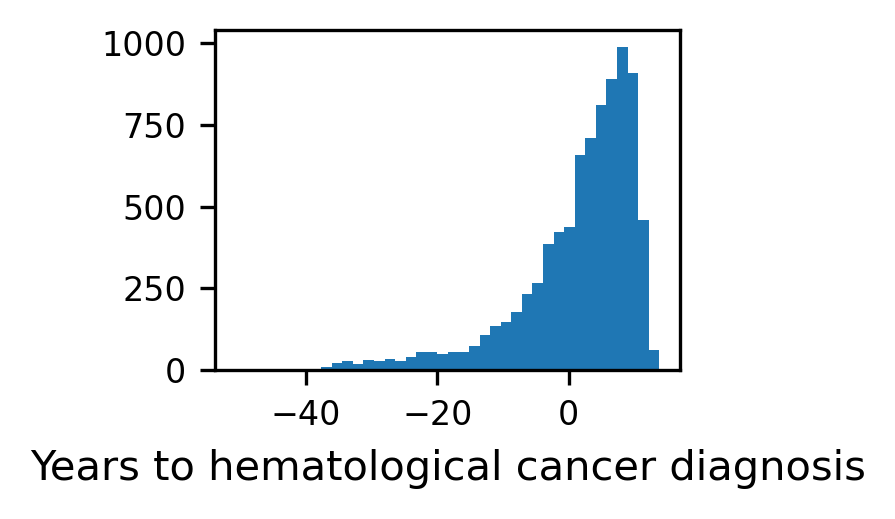

In [117]:
### Time between blood sample (potential CH diagnosis) and hematological cancer
# Positive means cancer AFTER blood sample
# Negative means cancer BEFORE blood sample

# ukb200K_age_cancer['yearsto_hematocan'] = ukb200K_age_cancer['hematocancer_age'] - ukb200K_age_cancer['age']
years = []
for n, x in enumerate(ukb200K_age_cancer['hematocancer_date']):
    if x is np.nan:
        years.append(x)
    else:
        year = pd.to_datetime(ukb200K_age_cancer.loc[n,'hematocancer_date'], format='%Y-%m-%d')-\
               pd.to_datetime(ukb200K_age_cancer.loc[n,'53-0.0'], format='%Y-%m-%d')
        years.append(year/np.timedelta64(1,'Y'))
ukb200K_age_cancer['yearsto_hematocan_dates'] = years

# plot
plt.rcParams["figure.figsize"] = (2,1.5)
graph = ukb200K_age_cancer['yearsto_hematocan_dates'].hist(bins=40)
graph.set(xlabel="Years to hematological cancer diagnosis")
graph.grid(False)
graph.tick_params(labelsize=8)
plt.show()

In [118]:
def hemato_cancer_post(x):
    if (x['hemato_cancer'] == 1) & (x['yearsto_hematocan_dates']>0):
        return 1
    else:
        return 0

ukb200K_age_cancer['hemato_cancer_post_dates'] = ukb200K_age_cancer.apply(lambda x: hemato_cancer_post(x), axis=1)
ukb200K_age_cancer['hemato_cancer_post_dates'].value_counts()

0    496587
1      5804
Name: hemato_cancer_post_dates, dtype: int64

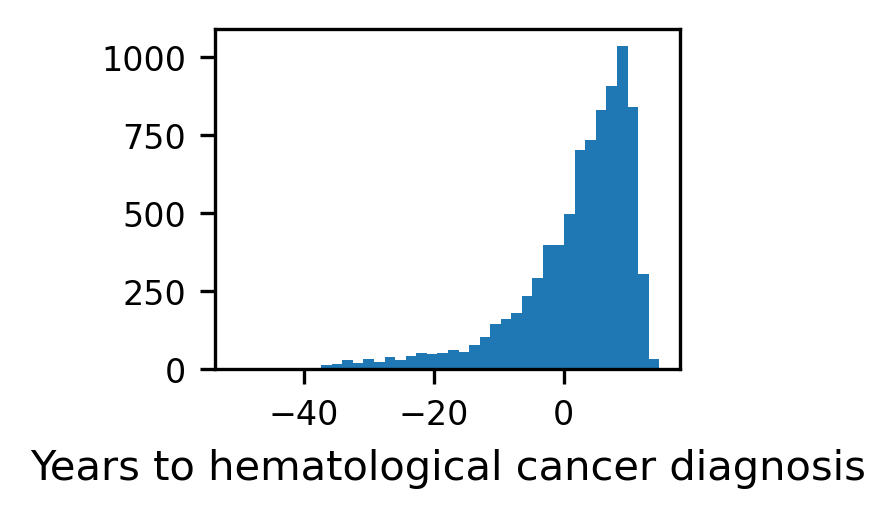

In [120]:
### Time between blood sample (potential CH diagnosis) and hematological cancer
# Positive means cancer AFTER blood sample
# Negative means cancer BEFORE blood sample

ukb200K_age_cancer['yearsto_hematocan'] = ukb200K_age_cancer['hematocancer_age'] - ukb200K_age_cancer['age_recruitment']

# plot
plt.rcParams["figure.figsize"] = (2,1.5)
graph = ukb200K_age_cancer['yearsto_hematocan'].hist(bins=40)
graph.set(xlabel="Years to hematological cancer diagnosis")
graph.grid(False)
graph.tick_params(labelsize=8)
plt.show()

In [121]:
def hemato_cancer_post(x):
    if (x['hemato_cancer'] == 1) & (x['yearsto_hematocan']>0):
        return 1
    else:
        return 0

ukb200K_age_cancer['hemato_cancer_post'] = ukb200K_age_cancer.apply(lambda x: hemato_cancer_post(x), axis=1)
ukb200K_age_cancer['hemato_cancer_post'].value_counts()

0    496505
1      5886
Name: hemato_cancer_post, dtype: int64

In [124]:
def hemato_cancer_pre(x):
    if (x['hemato_cancer'] == 1) & (x['yearsto_hematocan']<0):
        return 1
    else:
        return 0

ukb200K_age_cancer['hemato_cancer_pre'] = ukb200K_age_cancer.apply(lambda x: hemato_cancer_pre(x), axis=1)
ukb200K_age_cancer['hemato_cancer_pre'].value_counts()

0    499905
1      2486
Name: hemato_cancer_pre, dtype: int64

In [125]:
def hemato_cancer_pre_dates(x):
    if (x['hemato_cancer'] == 1) & (x['yearsto_hematocan_dates']<0):
        return 1
    else:
        return 0

ukb200K_age_cancer['hemato_cancer_pre_dates'] = ukb200K_age_cancer.apply(lambda x: hemato_cancer_pre_dates(x), axis=1)
ukb200K_age_cancer['hemato_cancer_pre_dates'].value_counts()

0    499799
1      2592
Name: hemato_cancer_pre_dates, dtype: int64

In [126]:
ukb200K_age_cancer[ukb200K_age_cancer['hemato_cancer_pre'] == 1]['hematocancer_type'].value_counts(normalize=True).head(15)*100

C833      8.889783
C911      8.326629
C829      7.843926
C859      7.763475
C900      6.194690
C811      4.384553
D45       3.901850
2019.0    3.258246
C921      3.097345
2028.0    2.896219
C819      2.775543
D471      2.654867
C920      2.614642
D472      2.534191
2015.0    2.333065
Name: hematocancer_type, dtype: float64

## 6. Create variable hematopoietic cancer from 1st cancer (post age)

In [127]:
### Patients with hematological cancer as first cancer ICD10

def hemato_1cancer(x):
    if pd.notna(x):
        if x.startswith(hemcancer_icd10):
            return 1
        else:
            return 0
    else:
        return 0

ukb200K_age_cancer['hemato_1cancer'] = ukb200K_age_cancer['type_1cancer'].apply(lambda x: hemato_1cancer(x))
ukb200K_age_cancer['hemato_1cancer'].value_counts()

0    495814
1      6577
Name: hemato_1cancer, dtype: int64

## 7. Labeling and classifying hematological cancer

In [128]:
ukb200K_age_cancer['hematocancer_type'].value_counts()

C833      1064
C900      1041
C911       919
C920       371
C829       370
          ... 
C843         1
C866         1
C814         1
C847         1
2081.0       1
Name: hematocancer_type, Length: 112, dtype: int64

In [129]:
### Codify hemato cancer type
### Gruped cathegories

### Regeneron C81-86, C91

def hemato_cancer_class(x):
    if pd.notna(x):
        # Lymphoid
        if x == 'C833':
            return 'DLBCL'
        elif x == 'C911':
            return 'CLL'
        elif (x == 'C900') | (x.startswith('2030')):
            return 'MM'
        elif x.startswith('C82'):
            return 'FL'
        elif (x.startswith('C81')) | (str(x).startswith('201')):
            return 'HL'
        elif x == 'D472':
            return 'MGUS'
        elif (x.startswith('C84')) | (x == 'C862'):
            return 'TCLymp'
        elif (x.startswith('C83')) | (x == 'C859') | (x.startswith('C85')) | (x == 'C902') | \
        (x == 'C901') | (x == 'C880') | (x == 'C884') | (x.startswith('202')):
            return 'Lymphomas-other'
        elif (x.startswith('C91')) | (x.startswith('2040')):
            return 'LymphLeu-other'
        # Myeloid
        elif (x == 'D471') | (x == 'D473') | (x == 'D45'):
            return 'MPNs'
        elif (x == 'C920') | (x.startswith('2050')):
            return 'AML'
        elif (x == 'C921') | (x.startswith('2051')):
            return 'CML'
        elif x.startswith('D46'):
            return 'MDS'
        elif (x.startswith('C92')) | (x.startswith('C93')) | (x == 'C940') | (x == 'D470') | (x == 'C946') | (x.startswith('206')):
            return 'Myeloid-other'
        # Other
        elif (x.startswith('C95')) | (x == 'C889') | (x == 'D479') | (x.startswith('C96')) \
        | (x.startswith('200')) | (x.startswith('2387')) | (x.startswith('208')):
            return 'Other_unknown'
        else:
            return '---others---'
         
ukb200K_age_cancer['hemato_cancer_class'] = ukb200K_age_cancer['hematocancer_type'].apply(lambda x: hemato_cancer_class(x))
ukb200K_age_cancer['hemato_cancer_class'].value_counts()

Lymphomas-other    1438
DLBCL              1064
MM                 1043
CLL                 919
FL                  771
MPNs                752
HL                  565
AML                 391
MDS                 338
TCLymp              263
LymphLeu-other      208
CML                 178
MGUS                159
Myeloid-other       143
Other_unknown       138
---others---         26
Name: hemato_cancer_class, dtype: int64

In [130]:
### Divide in Lymphoid/Myeloid

def lymphoid_myeloid(x):
    if pd.notna(x):
        if x in ['Lymphomas-other', 'DLBCL', 'CLL', 'MM', 'FL', 'HL', 'TCLymp', 'LymphLeu-other', 'MGUS']:
            return 'Lymphoid'
        elif x in ['MPNs', 'AML', 'MDS', 'CML', 'Myeloid-other']:
            return 'Myeloid'
        elif x == 'Other_unknown':
            return 'Unkown'
         
ukb200K_age_cancer['lymphoid_myeloid'] = ukb200K_age_cancer['hemato_cancer_class'].apply(lambda x: lymphoid_myeloid(x))
ukb200K_age_cancer['lymphoid_myeloid'].value_counts()

Lymphoid    6430
Myeloid     1802
Unkown       138
Name: lymphoid_myeloid, dtype: int64

In [131]:
# Check
print(sum(ukb200K_age_cancer['hematocancer_type'].value_counts()))
print(sum(ukb200K_age_cancer['hemato_cancer_class'].value_counts()))
print(sum(ukb200K_age_cancer['lymphoid_myeloid'].value_counts()))

8396
8396
8370


In [132]:
# Create lymphoid_cancer_post variable

def lymphoid_cancer_post(x):
    if (x['lymphoid_myeloid'] == 'Lymphoid') & (x['hemato_cancer_post'] == 1):
        return 1
    else:
        return 0

ukb200K_age_cancer['lymphoid_cancer_post'] = ukb200K_age_cancer.apply(lambda x: lymphoid_cancer_post(x), axis=1)
ukb200K_age_cancer['lymphoid_cancer_post'].value_counts()

0    497976
1      4415
Name: lymphoid_cancer_post, dtype: int64

In [133]:
# Create myeloid_cancer_post variable

def myeloid_cancer_post(x):
    if (x['lymphoid_myeloid'] == 'Myeloid') & (x['hemato_cancer_post'] == 1):
        return 1
    else:
        return 0

ukb200K_age_cancer['myeloid_cancer_post'] = ukb200K_age_cancer.apply(lambda x: myeloid_cancer_post(x), axis=1)
ukb200K_age_cancer['myeloid_cancer_post'].value_counts()

0    501030
1      1361
Name: myeloid_cancer_post, dtype: int64

## 8. Save output

In [48]:
# reorder columns
ukb200K_age_cancer = ukb200K_age_cancer[['patient', 'age_recruitment', 'age_group', 'eid',
       'cancer', 'cancer2+', 'age_1cancer',
       'years_tocancer1', 'cancer1_pre', 'type_1cancer', 'hemato_cancer',
       'hematocancer_icd10_type', 'hematocancer_icd10_age',
       'hematocancer_icd9_type', 'hematocancer_icd9_age', 'hematocancer_type',
       'hematocancer_age', 'hematocancer_icd10_date', 'hematocancer_icd9_date',
       'hematocancer_date', 'yearsto_hematocan', 'hemato_cancer_post',
       'hemato_cancer_pre', 'yearsto_hematocan_dates', 'hemato_cancer_post_dates',
       'hemato_cancer_pre_dates', 'hemato_1cancer', 'hemato_cancer_class',
       'lymphoid_myeloid', 'lymphoid_cancer_post', 'myeloid_cancer_post',
       '40005-0.0', '40005-1.0',
       '40005-2.0', '40005-3.0', '40005-4.0', '40005-5.0', '40005-6.0',
       '40005-7.0', '40006-0.0', '40006-1.0', '40006-2.0', '40006-3.0',
       '40006-4.0', '40006-5.0', '40006-6.0', '40006-7.0', '40008-0.0',
       '40008-1.0', '40008-2.0', '40008-3.0', '40008-4.0', '40008-5.0',
       '40008-6.0', '40008-7.0', '40013-0.0', '40013-1.0', '40013-2.0',
       '40013-3.0', '40013-4.0', '40013-5.0', '40013-6.0', '40013-7.0',
       '40009-0.0', ]]

In [49]:
# cancer_df2[['eid','53', '21003', '21022', '22009', '31']]
sublist = [i for i in cancer_df2.columns.tolist() if i.split('-')[0] in (['eid','53', '21003', '21022', '22009', '31'])][:21]
sublist
cancer_df3 = cancer_df2[sublist]

In [50]:
ukb200K_age_cancer_final = pd.merge(ukb200K_age_cancer, cancer_df3,  how='inner', on='eid')

In [140]:
### SAVE
ukb200K_age_cancer_final.to_csv('cancer_ukb450k_670124.txt.gz', sep="\t", index=False, compression='gzip')